In [2]:
from tractseg.data import dataset_specific_utils
from tractseg.libs.AFQ_MultiCompCorrection import AFQ_MultiCompCorrection
from tractseg.libs.AFQ_MultiCompCorrection import get_significant_areas
from tractseg.libs import metric_utils
from tractseg.libs import tracking
from tractseg.libs import tractometry
from dipy.tracking.utils import length

import os
import argparse
import math
from decimal import Decimal
from os.path import join

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import scipy.stats
import pandas as pd
from tqdm import tqdm

import glob as glob
import nibabel as nib
from scipy.stats import t as t_dist
from tractseg.libs import plot_utils
from sklearn.linear_model import LinearRegression

In [3]:
import seaborn as sns  # import in function to avoid error if not installed (this is only needed in this function)
from dipy.viz import actor, window
from tractseg.libs import vtk_utils
from scipy.ndimage.morphology import binary_dilation
from dipy.tracking.streamline import transform_streamlines
from scipy.ndimage.morphology import binary_dilation
from dipy.tracking.streamline import set_number_of_points
from dipy.tracking.streamline import length as sl_length
from dipy.tracking.streamline import Streamlines
from dipy.segment.clustering import QuickBundles
from dipy.segment.metric import AveragePointwiseEuclideanMetric
from scipy.spatial import cKDTree    /NAS/dumbo/protocoles/GAITnPARK/NAS/dumbo/protocoles/GAITnPARK
from tractseg.data import dataset_specific_utils
from tractseg.libs import fiber_utils
from tractseg.libs import img_utils

In [4]:
STUDY_PATH='/NAS/deathrow/protocoles/MEDU_ST_PHI/'
IMAGES_DIR=os.path.join(STUDY_PATH,'images')
TRACTO_DIR=os.path.join(STUDY_PATH,'tracto')
FILE_PATH=os.path.join(STUDY_PATH,'liste_pts.csv')

In [5]:
#!pip install -U dipy
#!pip install -U fury

In [6]:
import dipy as dp

In [7]:
!which pip

/home/global/anaconda37/bin/pip


In [8]:
dp.__version__

'1.4.0'

In [39]:
BValFile1=sorted(glob.glob(os.path.join(IMAGES_DIR,'*','*ORIG_DTI_MB_2500_600_15_9_3X3*.bval')))
BValFile2=sorted(glob.glob(os.path.join(IMAGES_DIR,'*','*ORIG_DTI_MB_4600_600_15_5_3X*.bval')))
BValFile3=sorted(glob.glob(os.path.join(IMAGES_DIR,'*','*ORIG_DTI_PAS_MB_4600_600_15_5_3X*.bval')))

BVecFile1=sorted(glob.glob(os.path.join(IMAGES_DIR,'*','*ORIG_DTI_MB_2500_600_15_9_3X3*.bvec')))
BVecFile2=sorted(glob.glob(os.path.join(IMAGES_DIR,'*','*ORIG_DTI_MB_4600_600_15_5_3X*.bvec')))
BVecFile3=sorted(glob.glob(os.path.join(IMAGES_DIR,'*','*ORIG_DTI_PAS_MB_4600_600_15_5_3X*.bvec')))
bval=BValFile1[1]
bvec=BVecFile1[1]
print(bvec)
!more bvec
gtab = dp.core.gradients.gradient_table(bval,bvec)
print(gtab.bvals)
print(gtab.bvecs)

/NAS/deathrow/protocoles/MEDU_ST_PHI/images/PAT00002/PAT00002_ORIG_DTI_MB_2500_600_15_9_3X3_20200217124848_40005.bvec
more: stat of bvec failed: No such file or directory
[  0. 600. 600. 600. 600. 600. 600. 600. 600. 600. 600. 600. 600. 600.
 600. 600.]
[[ 0.     0.     0.   ]
 [ 1.     0.     0.   ]
 [ 0.643  0.766  0.   ]
 [ 0.258  0.307  0.916]
 [ 0.745 -0.594  0.303]
 [ 0.164 -0.507  0.846]
 [-0.796 -0.321  0.513]
 [ 0.761  0.427  0.489]
 [-0.506  0.833  0.224]
 [ 0.667 -0.158  0.728]
 [ 0.128 -0.959  0.254]
 [-0.178 -0.898 -0.403]
 [ 0.255 -0.59  -0.767]
 [-0.34  -0.736  0.585]
 [-0.801  0.329  0.501]
 [ 0.336  0.043 -0.941]]


In [28]:
bvals,bvecs=dp.io.read_bvals_bvecs(BValFile1[1], BVecFile1[1])
gtab_ABCD=dp.io.gradient_table(bvals,bvecs)

NameError: name 'BVecFile1' is not defined

### Valeur de DTI par ROI

In [18]:
df = pd.DataFrame()
listeFilesROI=sorted(glob.glob(os.path.join(IMAGES_DIR,'*','ROIPAT*resliced.nii.gz')))
listeFile1=sorted(glob.glob(os.path.join(IMAGES_DIR,'*','PAT*ORIG_DTI_PAS_MB_4600_600_15_5_3X3*std.nii.gz')))
listeFile2=sorted(glob.glob(os.path.join(IMAGES_DIR,'*','PAT*ORIG_DTI_MB_4600_600_15_5_3X3*_std_r.nii.gz')))
listeFile3=sorted(glob.glob(os.path.join(IMAGES_DIR,'*','PAT*ORIG_DTI_MB_2500_600_15_9_3X3*_std_r.nii.gz')))
print(len(listeFilesROI),len(listeFile1),len(listeFile2),len(listeFile3))
for cpt,file in enumerate(listeFilesROI):
    SUBJ=file.split('/')[6]
#for x,y,z in zip(listeFile1,listeFile2,listeFile3):
    struct = nib.load(file)
    struct_data=np.asanyarray(struct.dataobj)
    print(file)
    for val in [50,100,200,255,300,400,500] :
        for filedata in [listeFile1,listeFile2,listeFile3]:
            #print(filedata[cpt])
            data1 = np.asanyarray(nib.load(filedata[cpt]).dataobj)
            if len(data1.shape) == 4 :
                data=data1[:,:,0:30,1]
            else :
                data=data1[:,:,0:30]
            res=np.mean(data[struct_data==val])
            print(res)
            df.loc[SUBJ,str(val)+"_"+filedata[cpt][filedata[cpt].find('ORIG'):filedata[cpt].find('3X3')-1]]=res
df.to_excel(os.path.join(STUDY_PATH,'ROIValues.xlsx'))

20 20 20 20
/NAS/deathrow/protocoles/MEDU_ST_PHI/images/PAT00001/ROIPAT00001_resliced.nii.gz
87.18181818181819
258.0
249.1818181818182
189.5
777.5
540.25
334.0
603.0
519.0
93.92307692307692
214.92307692307693
206.07692307692307
333.45454545454544
645.9090909090909
552.1818181818181
359.0
599.0
563.6
406.7
772.9
616.6
/NAS/deathrow/protocoles/MEDU_ST_PHI/images/PAT00002/ROIPAT00002_resliced.nii.gz
57.0
109.0
117.0
189.125
963.5
637.0
69.14285714285714
319.85714285714283
389.2857142857143
86.33333333333333
195.83333333333334
170.08333333333334
274.22222222222223
626.6666666666666
537.2222222222222
342.0
415.0
361.8
318.14285714285717
507.14285714285717
415.57142857142856
/NAS/deathrow/protocoles/MEDU_ST_PHI/images/PAT00003/ROIPAT00003_resliced.nii.gz
152.375
70.875
112.375
206.83333333333334
967.3333333333334
791.8333333333334
370.25
721.5
467.25
109.42857142857143
185.71428571428572
162.42857142857142
308.8
669.0
494.8
315.8333333333333
799.3333333333334
603.5
340.6666666666667
746.6666

### Valeur de FA et MD par ROI

In [6]:
fa = pd.DataFrame()
md = pd.DataFrame()
b0 = pd.DataFrame()
listeFilesROI=sorted(glob.glob(os.path.join(TRACTO_DIR,'*','*','ROIPAT*resliced.nii.gz')))
print(len(listeFilesROI))
for cpt,file in enumerate(listeFilesROI):
    SUBJ=file.split('/')[6]
    DIR=file.split('/')[7]
    print(file,SUBJ,DIR)
    struct = nib.load(file)
    struct_data=np.asanyarray(struct.dataobj)
    datafa = np.asanyarray(nib.load(os.path.join(TRACTO_DIR,SUBJ,DIR,'fa_'+SUBJ+'_'+DIR+'.nii.gz')).dataobj)
    datamd = np.asanyarray(nib.load(os.path.join(TRACTO_DIR,SUBJ,DIR,'adc_'+SUBJ+'_'+DIR+'.nii.gz')).dataobj)
    datab0 = np.asanyarray(nib.load(os.path.join(TRACTO_DIR,SUBJ,DIR,'b0.nii.gz')).dataobj)
    for val in [10,50,100,255,200,300,400,500] :
        res=np.mean(datafa[struct_data==val])
        fa.loc[SUBJ,str(val)+"_"+DIR[DIR.find('ORIG_DTI_')+9:DIR.find('_15_')-1]]=res
        res=np.mean(datamd[struct_data==val])
        md.loc[SUBJ,str(val)+"_"+DIR[DIR.find('ORIG_DTI_')+9:DIR.find('_15_')-1]]=res
        res=np.mean(datab0[struct_data==val])
        b0.loc[SUBJ,str(val)+"_mean_"+DIR[DIR.find('ORIG_DTI_')+9:DIR.find('_15_')-1]]=res
        res=np.std(datab0[struct_data==val])
        b0.loc[SUBJ,str(val)+"-std_"+DIR[DIR.find('ORIG_DTI_')+9:DIR.find('_15_')-1]]=res        
        
        
fa.to_excel(os.path.join(STUDY_PATH,'FA_ROIValues_V2.xlsx'))
md.to_excel(os.path.join(STUDY_PATH,'MD_ROIValues_V2.xlsx'))
b0.to_excel(os.path.join(STUDY_PATH,'B0_ROIValues_V2.xlsx'))

60
/NAS/deathrow/protocoles/MEDU_ST_PHI/tracto/PAT00001/ORIG_DTI_MB_2500_600_15_9_3X3/ROIPAT00001_resliced.nii.gz PAT00001 ORIG_DTI_MB_2500_600_15_9_3X3
/NAS/deathrow/protocoles/MEDU_ST_PHI/tracto/PAT00001/ORIG_DTI_MB_4600_600_15_5_3X3/ROIPAT00001_resliced.nii.gz PAT00001 ORIG_DTI_MB_4600_600_15_5_3X3
/NAS/deathrow/protocoles/MEDU_ST_PHI/tracto/PAT00001/ORIG_DTI_PAS_MB_4600_600_15_5_3X3/ROIPAT00001_resliced.nii.gz PAT00001 ORIG_DTI_PAS_MB_4600_600_15_5_3X3
/NAS/deathrow/protocoles/MEDU_ST_PHI/tracto/PAT00002/ORIG_DTI_MB_2500_600_15_9_3X3/ROIPAT00002_resliced.nii.gz PAT00002 ORIG_DTI_MB_2500_600_15_9_3X3
/NAS/deathrow/protocoles/MEDU_ST_PHI/tracto/PAT00002/ORIG_DTI_MB_4600_600_15_5_3X3/ROIPAT00002_resliced.nii.gz PAT00002 ORIG_DTI_MB_4600_600_15_5_3X3
/NAS/deathrow/protocoles/MEDU_ST_PHI/tracto/PAT00002/ORIG_DTI_PAS_MB_4600_600_15_5_3X3/ROIPAT00002_resliced.nii.gz PAT00002 ORIG_DTI_PAS_MB_4600_600_15_5_3X3
/NAS/deathrow/protocoles/MEDU_ST_PHI/tracto/PAT00003/ORIG_DTI_MB_2500_600_15_9_3X

### Valeur de FA par track (avant après exlcu / pondéré ou non pondéré)

In [11]:
fa = pd.DataFrame()
listeFilesROI=sorted(glob.glob(os.path.join(TRACTO_DIR,'*','*','*_prob_10000_filtered_map.nii.gz')))
print(len(listeFilesROI))
for cpt,file in enumerate(listeFilesROI):
    SUBJ=file.split('/')[6]
    DIR=file.split('/')[7]
    #print(file,SUBJ,DIR)
    struct = nib.load(file)
    struct_data=np.asanyarray(struct.dataobj)
    print(file)
    print(np.min(struct_data))
    print(np.max(struct_data))
    datafa = np.asanyarray(nib.load(os.path.join(TRACTO_DIR,SUBJ,DIR,'fa_'+SUBJ+'_'+DIR+'.nii.gz')).dataobj)
    
    print(np.nansum(datafa * struct_data)/np.nansum(struct_data))
    
    #for val in [10,50,100,255,200,300,400,500] :
    #    res=np.mean(datafa[struct_data==val])
    #    fa.loc[SUBJ,str(val)+"_"+DIR[DIR.find('ORIG_DTI_')+9:DIR.find('_15_')-1]]=res    

240
/NAS/deathrow/protocoles/MEDU_ST_PHI/tracto/PAT00001/ORIG_DTI_MB_2500_600_15_9_3X3/tracks_L4_L_prob_10000_filtered_map.nii.gz
0
3660
0.25871192790897585
/NAS/deathrow/protocoles/MEDU_ST_PHI/tracto/PAT00001/ORIG_DTI_MB_2500_600_15_9_3X3/tracks_L4_R_prob_10000_filtered_map.nii.gz
0
1990
0.30901198415875497
/NAS/deathrow/protocoles/MEDU_ST_PHI/tracto/PAT00001/ORIG_DTI_MB_2500_600_15_9_3X3/tracks_L5_L_prob_10000_filtered_map.nii.gz
0
2628
0.24831485918115268
/NAS/deathrow/protocoles/MEDU_ST_PHI/tracto/PAT00001/ORIG_DTI_MB_2500_600_15_9_3X3/tracks_L5_R_prob_10000_filtered_map.nii.gz
0
1942
0.3846564527368219
/NAS/deathrow/protocoles/MEDU_ST_PHI/tracto/PAT00001/ORIG_DTI_MB_4600_600_15_5_3X3/tracks_L4_L_prob_10000_filtered_map.nii.gz
0
5452
0.24062320795091988
/NAS/deathrow/protocoles/MEDU_ST_PHI/tracto/PAT00001/ORIG_DTI_MB_4600_600_15_5_3X3/tracks_L4_R_prob_10000_filtered_map.nii.gz
0
3549
0.30246345851538775
/NAS/deathrow/protocoles/MEDU_ST_PHI/tracto/PAT00001/ORIG_DTI_MB_4600_600_15_5_

In [24]:
listeFilesROI=sorted(glob.glob(os.path.join(IMAGES_DIR,'*','ROIPAT*resliced.nii.gz')))
listeFile1=sorted(glob.glob(os.path.join(IMAGES_DIR,'*','PAT*ORIG_DTI_PAS_MB_4600_600_15_5_3X3*std.nii.gz')))
listeFile2=sorted(glob.glob(os.path.join(IMAGES_DIR,'*','PAT*ORIG_DTI_MB_4600_600_15_5_3X3*_std_r.nii.gz')))
listeFile3=sorted(glob.glob(os.path.join(IMAGES_DIR,'*','PAT*ORIG_DTI_MB_2500_600_15_9_3X3*_std_r.nii.gz')))
for v,x,y,z in zip(listeFilesROI,listeFile1,listeFile2,listeFile3):
    CMD="freeview "+v+" "+x+" "+y+" "+z
    print(CMD)

freeview /NAS/deathrow/protocoles/MEDU_ST_PHI/images/PAT00001/ROIPAT00001_resliced.nii.gz /NAS/deathrow/protocoles/MEDU_ST_PHI/images/PAT00001/PAT00001_ORIG_DTI_PAS_MB_4600_600_15_5_3X3_40004_std.nii.gz /NAS/deathrow/protocoles/MEDU_ST_PHI/images/PAT00001/PAT00001_ORIG_DTI_MB_4600_600_15_5_3X3_40006_std_r.nii.gz /NAS/deathrow/protocoles/MEDU_ST_PHI/images/PAT00001/PAT00001_ORIG_DTI_MB_2500_600_15_9_3X3_40005_std_r.nii.gz
freeview /NAS/deathrow/protocoles/MEDU_ST_PHI/images/PAT00002/ROIPAT00002_resliced.nii.gz /NAS/deathrow/protocoles/MEDU_ST_PHI/images/PAT00002/PAT00002_ORIG_DTI_PAS_MB_4600_600_15_5_3X3_20200217124848_40004_std.nii.gz /NAS/deathrow/protocoles/MEDU_ST_PHI/images/PAT00002/PAT00002_ORIG_DTI_MB_4600_600_15_5_3X3_20200217124848_40006_std_r.nii.gz /NAS/deathrow/protocoles/MEDU_ST_PHI/images/PAT00002/PAT00002_ORIG_DTI_MB_2500_600_15_9_3X3_20200217124848_40005_std_r.nii.gz
freeview /NAS/deathrow/protocoles/MEDU_ST_PHI/images/PAT00003/ROIPAT00003_resliced.nii.gz /NAS/deathrow/p

In [25]:
listeFilesROI=sorted(glob.glob(os.path.join(IMAGES_DIR,'*','ROIPAT*resliced.nii.gz')))
listeFile1=sorted(glob.glob(os.path.join(IMAGES_DIR,'*','PAT*ORIG_DTI_PAS_MB_4600_600_15_5_3X3*.nii')))
listeFile2=sorted(glob.glob(os.path.join(IMAGES_DIR,'*','PAT*ORIG_DTI_MB_4600_600_15_5_3X3*.nii')))
listeFile3=sorted(glob.glob(os.path.join(IMAGES_DIR,'*','PAT*ORIG_DTI_MB_2500_600_15_9_3X3*.nii')))
for v,x,y,z in zip(listeFilesROI,listeFile1,listeFile2,listeFile3):
    CMD="freeview "+v+" "+x+" "+y+" "+z
    print(CMD)

freeview /NAS/deathrow/protocoles/MEDU_ST_PHI/images/PAT00001/ROIPAT00001_resliced.nii.gz /NAS/deathrow/protocoles/MEDU_ST_PHI/images/PAT00001/PAT00001_ORIG_DTI_PAS_MB_4600_600_15_5_3X3_40004.nii /NAS/deathrow/protocoles/MEDU_ST_PHI/images/PAT00001/PAT00001_ORIG_DTI_MB_4600_600_15_5_3X3_40006.nii /NAS/deathrow/protocoles/MEDU_ST_PHI/images/PAT00001/PAT00001_ORIG_DTI_MB_2500_600_15_9_3X3_40005.nii
freeview /NAS/deathrow/protocoles/MEDU_ST_PHI/images/PAT00002/ROIPAT00002_resliced.nii.gz /NAS/deathrow/protocoles/MEDU_ST_PHI/images/PAT00002/PAT00002_ORIG_DTI_PAS_MB_4600_600_15_5_3X3_20200217124848_40004.nii /NAS/deathrow/protocoles/MEDU_ST_PHI/images/PAT00002/PAT00002_ORIG_DTI_MB_4600_600_15_5_3X3_20200217124848_40006.nii /NAS/deathrow/protocoles/MEDU_ST_PHI/images/PAT00002/PAT00002_ORIG_DTI_MB_2500_600_15_9_3X3_20200217124848_40005.nii
freeview /NAS/deathrow/protocoles/MEDU_ST_PHI/images/PAT00003/ROIPAT00003_resliced.nii.gz /NAS/deathrow/protocoles/MEDU_ST_PHI/images/PAT00003/PAT00003_ORI

In [47]:
listeFilesROI=sorted(glob.glob(os.path.join(IMAGES_DIR,'*','ROIPAT*resliced.nii.gz')))
for cpt,file in enumerate(listeFilesROI):
    for seq in ['ORIG_DTI_PAS_MB_4600_600_15_5_3X3','ORIG_DTI_MB_4600_600_15_5_3X3','ORIG_DTI_MB_2500_600_15_9_3X3']:
        subj=file.split('/')[6]  
        if (not os.path.exists(os.path.join(TRACTO_DIR,subj,seq,"fa_"+subj+"_"+seq+".nii.gz"))) :
            cmd="qbatch -q two_job_q -oe /NAS/deathrow/protocoles/MEDU_ST_PHI/code/log/ -N "+subj+"_"+seq+" /NAS/deathrow/protocoles/MEDU_ST_PHI/code/runbash.sh  "+subj+" "+seq
            print(cmd)

In [20]:
for NR_POINTS in ([98]):
    for ALGORITHM in (['''distance_map''']):
        for PARA in (['''fa''']): 
            for BUNDLE in (['''L5_L''','''L5_R''','''L4_L''','''L4_R''']):  
                for SEQ in (['''ORIG_DTI_PAS_MB_4600_600_15_5_3X3''','''ORIG_DTI_MB_2500_600_15_9_3X3''','''ORIG_DTI_MB_4600_600_15_5_3X3''']):
                    print(NR_POINTS,ALGORITHM,PARA,BUNDLE,SEQ)
                    listFiles = glob.glob(os.path.join(TRACTO_DIR,"PAT0*",SEQ,'tracks_'+BUNDLE+'_prob_10000_filtered_exclu.tck'))
                    npvalues2 = []# np.zeros([0,NR_POINTS])
                    for file in listFiles:
                        #npyFile=str.replace(file,'tck','npy')
                        #if os.path.exists(npyFile) :
                        #    npvalues=np.load(npyFile)
                        #else :  
                            #npvalues = np.zeros([len(df),NR_POINTS])
                            #for idx, jdx in df.iterrows():
                            #    SUBJ=df.iloc[idx]['subject_id'] # df.subject_id[0] ou encore jdx['subject_id']
                            #listSubj=['PAT00002','PAT00003','PAT00009','PAT00010','PAT00012','PAT00013']
                        #for idx,SUBJ in enumerate(listSubj):
                        print(file)
                        TRACTO_TCK=os.path.join(file)
                        SCALAR_IMG=os.path.join(os.path.join(os.path.dirname(file),'fa_'+str.split(file,sep='/')[6]+'_'+str.split(file,sep='/')[7]+'.nii.gz'))
                        START_IMG=os.path.join(os.path.dirname(file),'ROI_F.nii.gz')
                        scalar_image = nib.load(SCALAR_IMG)
                        beginnings = nib.load(START_IMG)
                        sl_file = nib.streamlines.load(TRACTO_TCK)
                        streamlines = sl_file.streamlines
                        val=list(length(streamlines))
                        #print(val)
                        print(len(streamlines))
                        if len(streamlines) > 5 :
                            mean, std = tractometry.evaluate_along_streamlines(np.nan_to_num(scalar_image.get_fdata()), streamlines,beginnings.get_fdata(), NR_POINTS+2, dilate=5,predicted_peaks=None, affine=scalar_image.affine)
                            npvalues2.append(mean[1:-1])
                        else :
                            print('oups')
                    #np.save(os.path.join(STUDY_PATH,PARA+"_"+BUNDLE+"_"+ALGORITHM+"_"+str(NR_POINTS)),npvalues)
                    sns.set(font_scale=1.2)
                    sns.set_style("whitegrid")                    
                    %matplotlib inline
                    ax = sns.lineplot(x="variable", y="value", data=pd.DataFrame(npvalues2).melt())
                    ax.set(xlabel='position along tract', ylabel=PARA)
                    ax.set_title(BUNDLE+'_'+SEQ)
                    plt.tight_layout()
                    #plt.savefig(os.path.join(STUDY_PATH,"screenshots",PARA+"_"+BUNDLE+"_"+ALGORITHM+"_"+str(NR_POINTS)+".png"), dpi=300)
                    plt.show()
                    plt.close()  
                
                    break
                break

98 distance_map fa L5_L ORIG_DTI_PAS_MB_4600_600_15_5_3X3
/NAS/deathrow/protocoles/MEDU_ST_PHI/tracto/PAT00001/ORIG_DTI_PAS_MB_4600_600_15_5_3X3/tracks_L5_L_prob_10000_filtered_exclu.tck
6065
/NAS/deathrow/protocoles/MEDU_ST_PHI/tracto/PAT00003/ORIG_DTI_PAS_MB_4600_600_15_5_3X3/tracks_L5_L_prob_10000_filtered_exclu.tck
2611
/NAS/deathrow/protocoles/MEDU_ST_PHI/tracto/PAT00002/ORIG_DTI_PAS_MB_4600_600_15_5_3X3/tracks_L5_L_prob_10000_filtered_exclu.tck
5746
/NAS/deathrow/protocoles/MEDU_ST_PHI/tracto/PAT00007/ORIG_DTI_PAS_MB_4600_600_15_5_3X3/tracks_L5_L_prob_10000_filtered_exclu.tck
2152
/NAS/deathrow/protocoles/MEDU_ST_PHI/tracto/PAT00006/ORIG_DTI_PAS_MB_4600_600_15_5_3X3/tracks_L5_L_prob_10000_filtered_exclu.tck
2345
/NAS/deathrow/protocoles/MEDU_ST_PHI/tracto/PAT00005/ORIG_DTI_PAS_MB_4600_600_15_5_3X3/tracks_L5_L_prob_10000_filtered_exclu.tck
4068


IndexError: index 30 is out of bounds for axis 2 with size 30

### Avec AFQ de Dipy

In [30]:
fa = pd.DataFrame()
listeFilesROI=sorted(glob.glob(os.path.join(TRACTO_DIR,'*','*','*_prob_10000_filtered_exclu.tck')))
    
#feature = ResampleFeature(nb_points=102)
#metric = AveragePointwiseEuclideanMetric(feature)

NR_POINTS=98
ALGORITHM='''distance_map'''
PARA='''fa''' 
npvalues = []# np.zeros([0,NR_POINTS])
for cpt,file in enumerate(listeFilesROI):
    SUBJ=file.split('/')[6]
    DIR=file.split('/')[7]
    
    TRACTO_TCK=os.path.join(file)
    SCALAR_IMG=os.path.join(TRACTO_DIR,SUBJ,DIR,'fa_'+SUBJ+'_'+DIR+'.nii.gz')

    START_IMG=os.path.join(os.path.dirname(file),'ROI_F.nii.gz')
    scalar_image = nib.load(SCALAR_IMG)
    beginnings = nib.load(START_IMG)
    sl_file = nib.streamlines.load(TRACTO_TCK)
    streamlines = sl_file.streamlines

    if (len(streamlines) > 5):
        print(file)
        #cluster_bundle = qb.cluster(model_cst_l)
        #standard_bundle = cluster_bundle.centroids[0]
        w_cst_l = dsa.gaussian_weights(streamlines)
        profile_ = dsa.afq_profile(np.nan_to_num(scalar_image.get_fdata()), streamlines,scalar_image.affine,n_points=NR_POINTS+2,weights=w_cst_l)
        npvalues.append(profile_[1:-1])
                        
print(npvalues)
data_nd=np.asarray(npvalues)
np.savetxt(os.path.join(STUDY_PATH,'profiles'+str(NR_POINTS)+'.csv'),data_nd,fmt='%1.2d')

/NAS/deathrow/protocoles/MEDU_ST_PHI/tracto/PAT00001/ORIG_DTI_MB_2500_600_15_9_3X3/tracks_L4_L_prob_10000_filtered_exclu.tck
/NAS/deathrow/protocoles/MEDU_ST_PHI/tracto/PAT00001/ORIG_DTI_MB_2500_600_15_9_3X3/tracks_L4_R_prob_10000_filtered_exclu.tck
/NAS/deathrow/protocoles/MEDU_ST_PHI/tracto/PAT00001/ORIG_DTI_MB_2500_600_15_9_3X3/tracks_L5_L_prob_10000_filtered_exclu.tck
/NAS/deathrow/protocoles/MEDU_ST_PHI/tracto/PAT00001/ORIG_DTI_MB_2500_600_15_9_3X3/tracks_L5_R_prob_10000_filtered_exclu.tck
/NAS/deathrow/protocoles/MEDU_ST_PHI/tracto/PAT00001/ORIG_DTI_MB_4600_600_15_5_3X3/tracks_L4_L_prob_10000_filtered_exclu.tck
/NAS/deathrow/protocoles/MEDU_ST_PHI/tracto/PAT00001/ORIG_DTI_MB_4600_600_15_5_3X3/tracks_L4_R_prob_10000_filtered_exclu.tck
/NAS/deathrow/protocoles/MEDU_ST_PHI/tracto/PAT00001/ORIG_DTI_MB_4600_600_15_5_3X3/tracks_L5_L_prob_10000_filtered_exclu.tck
/NAS/deathrow/protocoles/MEDU_ST_PHI/tracto/PAT00001/ORIG_DTI_MB_4600_600_15_5_3X3/tracks_L5_R_prob_10000_filtered_exclu.tck


In [31]:
np.savetxt(os.path.join(STUDY_PATH,'profiles'+str(NR_POINTS)+'.csv'),data_nd)

98 distance_map fa L5_L ORIG_DTI_PAS_MB_4600_600_15_5_3X3
/NAS/deathrow/protocoles/MEDU_ST_PHI/tracto/PAT00001/ORIG_DTI_PAS_MB_4600_600_15_5_3X3/tracks_L5_L_prob_10000_filtered_exclu.tck
/NAS/deathrow/protocoles/MEDU_ST_PHI/tracto/PAT00003/ORIG_DTI_PAS_MB_4600_600_15_5_3X3/tracks_L5_L_prob_10000_filtered_exclu.tck
/NAS/deathrow/protocoles/MEDU_ST_PHI/tracto/PAT00002/ORIG_DTI_PAS_MB_4600_600_15_5_3X3/tracks_L5_L_prob_10000_filtered_exclu.tck
/NAS/deathrow/protocoles/MEDU_ST_PHI/tracto/PAT00007/ORIG_DTI_PAS_MB_4600_600_15_5_3X3/tracks_L5_L_prob_10000_filtered_exclu.tck
/NAS/deathrow/protocoles/MEDU_ST_PHI/tracto/PAT00006/ORIG_DTI_PAS_MB_4600_600_15_5_3X3/tracks_L5_L_prob_10000_filtered_exclu.tck
/NAS/deathrow/protocoles/MEDU_ST_PHI/tracto/PAT00005/ORIG_DTI_PAS_MB_4600_600_15_5_3X3/tracks_L5_L_prob_10000_filtered_exclu.tck
/NAS/deathrow/protocoles/MEDU_ST_PHI/tracto/PAT00009/ORIG_DTI_PAS_MB_4600_600_15_5_3X3/tracks_L5_L_prob_10000_filtered_exclu.tck
/NAS/deathrow/protocoles/MEDU_ST_PHI/tr

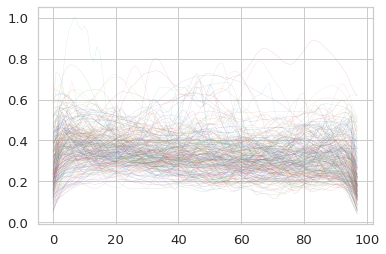

In [23]:
import dipy.stats.analysis as dsa
import dipy.tracking.streamline as dts
from dipy.segment.clustering import QuickBundles
from dipy.segment.metric import (AveragePointwiseEuclideanMetric,ResampleFeature)
feature = ResampleFeature(nb_points=100)
metric = AveragePointwiseEuclideanMetric(feature)

for NR_POINTS in ([98]):
    for ALGORITHM in (['''distance_map''']):
        for PARA in (['''fa''']): 
            for BUNDLE in (['''L5_L''','''L5_R''','''L4_L''','''L4_R''']):  
                for SEQ in (['''ORIG_DTI_PAS_MB_4600_600_15_5_3X3''','''ORIG_DTI_MB_4600_600_15_5_3X3''','''ORIG_DTI_MB_2500_600_15_9_3X3''']):
                    print(NR_POINTS,ALGORITHM,PARA,BUNDLE,SEQ)
                    listFiles = glob.glob(os.path.join(TRACTO_DIR,"PAT0*",SEQ,'tracks_'+BUNDLE+'_prob_10000_filtered_exclu.tck'))
                    npvalues = []# np.zeros([0,NR_POINTS])
                    for file in listFiles:
                        TRACTO_TCK=os.path.join(file)
                        SCALAR_IMG=os.path.join(os.path.join(os.path.dirname(file),'fa_'+str.split(file,sep='/')[6]+'_'+str.split(file,sep='/')[7]+'.nii.gz'))
                        START_IMG=os.path.join(os.path.dirname(file),'ROI_F.nii.gz')
                        scalar_image = nib.load(SCALAR_IMG)
                        beginnings = nib.load(START_IMG)
                        sl_file = nib.streamlines.load(TRACTO_TCK)
                        streamlines = sl_file.streamlines

                        if (len(streamlines) > 5):
                            print(file)
                            #cluster_bundle = qb.cluster(model_cst_l)
                            #standard_bundle = cluster_bundle.centroids[0]
                            w_cst_l = dsa.gaussian_weights(streamlines)
                            profile_ = dsa.afq_profile(np.nan_to_num(scalar_image.get_fdata()), streamlines,scalar_image.affine,n_points=NR_POINTS+2,weights=w_cst_l)
                            npvalues.append(profile_[1:-1])
                        
                    data_nd=np.asarray(npvalues)
                    np.savetxt(os.path.join(STUDY_PATH,ALGORITHM+PARA+BUNDLE+SEQ+str(NR_POINTS)+'.csv'),data_nd,fmt='%1.2d')
                    plt.plot(np.transpose(data_nd),linewidth=0.1)
                    plt.savefig(os.path.join(STUDY_PATH,ALGORITHM+PARA+BUNDLE+SEQ+str(NR_POINTS)+'.jpg'))
                    

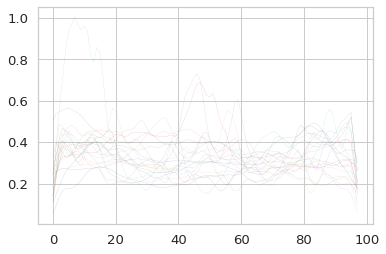

In [22]:
                    np.savetxt(os.path.join(STUDY_PATH,ALGORITHM+PARA+BUNDLE+SEQ+str(NR_POINTS)+'.csv'),data_nd,fmt='%1.2d')
                    plt.plot(np.transpose(data_nd),linewidth=0.1)
                    plt.savefig(os.path.join(STUDY_PATH,ALGORITHM+PARA+BUNDLE+SEQ+str(NR_POINTS)+'.jpg'))

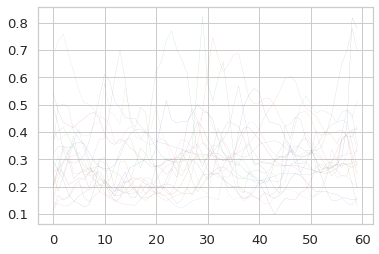

In [12]:
data_nd=np.asarray(npvalues2)
plt.plot(np.transpose(data_nd),linewidth=0.1)
plt.show()

(18, 98)
(18, 98)


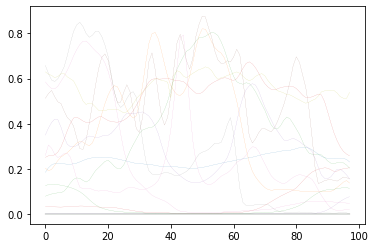

In [75]:

data_nd=np.asarray(npvalues)
print(data_nd.shape)
#data=stats.zscore(data_nd[np.mean(data_nd,axis=1)>0.3],axis=1)
data=data_nd
print(data.shape)

#plt.plot(np.median(data,axis=0),'b')
#plt.fill_between(np.linspace(1,98,98),np.percentile(data,25,axis=0),np.percentile(data,75,axis=0))
plt.plot(np.transpose(data),linewidth=0.1)

#plt.plot(numpy.percentile(data,75,axis=0))
#plt.plot(numpy.flipud(numpy.mean(CST_right_nd[numpy.mean(CST_right_nd,axis=1)>0.3],axis=0)))
plt.show()

In [27]:
hue = (0.0, 0.0)  # red only
saturation = (0.0, 1.0)  # white to red
img_size = (1000,500)
lut_cmap = actor.colormap_lookup_table(hue_range=hue,
                                       saturation_range=saturation)
renderer = window.Renderer()        
renderer.clear()

SUBJ="PAT00001"
SEQ="ORIG_DTI_PAS_MB_4600_600_15_5_3X3"
print(SUBJ)

for PARA in (['''fa''']): 
    ##ATTENTION j'ai reorienté la FA en LAS afin que ce soit comme les ROIS
    #mri_convert.bin tracto/PAT00003/fa.nii.gz tracto/PAT00003/fa_reorient.nii.gz --out_orientation LAS
    SCALAR_IMG=os.path.join(TRACTO_DIR,SUBJ,SEQ,PARA+'_'+SUBJ+'_'+SEQ+'.nii.gz')      
    scalar_image = nib.load(SCALAR_IMG)
    FA = scalar_image.get_data()
    for BUNDLE in (['''L5_L''','''L5_R''','''L4_L''','''L4_R''']):  
        TRACTO_TCK=os.path.join(TRACTO_DIR,SUBJ,SEQ,'tracks_'+BUNDLE+'_prob_10000_filtered_exclu.tck')        
        sl_file = nib.streamlines.load(TRACTO_TCK)
        streamlines = sl_file.streamlines
        streamlines = list(transform_streamlines(streamlines, np.linalg.inv(scalar_image.affine)))
        #sl_actor = actor.streamtube(streamlines, FA, linewidth=0.1, opacity=0.2)
        sl_actor = actor.line(streamlines, FA, linewidth=0.1,lookup_colormap=lut_cmap)
        renderer.add(sl_actor)

bar2 = actor.scalar_bar(lut_cmap)
renderer.add(bar2)
window.show(renderer, size=img_size, reset_camera=False)
    #window.record(renderer, out_path=os.path.join(IMAGES_DIR,SUBJ,SUBJ+'_GlobalView.jpg'), size=img_size)
# window.show(renderer, size=(600, 600), reset_camera=False)

/home/global/anaconda37/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Renderer() deprecated, Please use Scene()instead

* deprecated from version: 0.2.0
* Will raise <class 'fury.deprecator.ExpiredDeprecationError'> as of version: 0.6.0
  
/home/global/anaconda37/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


PAT00001


In [86]:
hue = (0.0, 0.0)  # red only
saturation = (0.0, 1.0)  # white to red
img_size = (1000,500)
lut_cmap = actor.colormap_lookup_table(hue_range=hue,
                                       saturation_range=saturation)
for idx, jdx in df.iterrows():
    renderer = window.Renderer()        
    renderer.clear()
    
    SUBJ=df.iloc[idx]['subject_id'] # df.subject_id[0] ou encore jdx['subject_id']
    print(SUBJ)
    for PARA in (['''fa''']): 
        ##ATTENTION j'ai reorienté la FA en LAS afin que ce soit comme les ROIS
        #mri_convert.bin tracto/PAT00003/fa.nii.gz tracto/PAT00003/fa_reorient.nii.gz --out_orientation LAS
        SCALAR_IMG=os.path.join(TRACTO_DIR,SUBJ,PARA+'_reorient.nii.gz')
        scalar_image = nib.load(SCALAR_IMG)
        FA = scalar_image.get_data()
        for BUNDLE in (['''L4L5_L''','''L4L5_R''','''L5S1_L''','''L5S1_R''','''S1S2_L''','''S1S2_R''']):  
            TRACTO_TCK=os.path.join(TRACTO_DIR,SUBJ,'tracks_'+BUNDLE+'_prob_5000.tck')        
            sl_file = nib.streamlines.load(TRACTO_TCK)
            streamlines = sl_file.streamlines
            streamlines = list(transform_streamlines(streamlines, np.linalg.inv(scalar_image.affine)))
            #sl_actor = actor.streamtube(streamlines, FA, linewidth=0.1, opacity=0.2)
            sl_actor = actor.line(streamlines, FA, linewidth=0.1,lookup_colormap=lut_cmap)
            renderer.add(sl_actor)
    
            ROI_IMG=os.path.join(IMAGES_DIR,SUBJ,'ROI_'+BUNDLE+'.nii.gz')
            ROI = nib.load(ROI_IMG)
            mask = ROI.get_data()
            #test1=np.eye(4)
            #test2=scalar_image.affine-ROI.affine
            #test1[1,3]=test2[1,3]
            #test1[1,1]=-1
            #print(test2)
            #print(test1)
            cont_actor = vtk_utils.contour_from_roi_smooth(mask, affine=np.eye(4), color=[.1, .9, .1], opacity=.8,smoothing=1)
            renderer.add(cont_actor)
        
    bar2 = actor.scalar_bar(lut_cmap)
    renderer.add(bar2)
    window.show(renderer, size=img_size, reset_camera=False)
    window.record(renderer, out_path=os.path.join(IMAGES_DIR,SUBJ,SUBJ+'_GlobalView.jpg'), size=img_size)
# window.show(renderer, size=(600, 600), reset_camera=False)

/home/global/anaconda37/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Renderer() deprecated, Please use Scene()instead

* deprecated from version: 0.2.0
* Will raise <class 'fury.deprecator.ExpiredDeprecationError'> as of version: 0.6.0
  import sys
/home/global/anaconda37/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/home/global/anaconda37/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from versio

PAT00002
PAT00003


In [74]:
print(np.eye(4))

test1=np.eye(4)
test2=scalar_image.affine-ROI.affine
test1[1,3]=test2[1,3]
test1[1,1]=-1
print(test1)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[  1.           0.           0.           0.        ]
 [  0.          -1.           0.         298.83450317]
 [  0.           0.           1.           0.        ]
 [  0.           0.           0.           1.        ]]


In [15]:
def _add_extra_point_to_last_streamline(sl):
    # Coloring broken as soon as all streamlines have same number of points -> why???
    # Add one number to last streamline to make it have a different number
    sl[-1] = np.append(sl[-1], [sl[-1][-1]], axis=0)
    return sl

In [36]:
# Settings
NR_SEGMENTS = NR_POINTS+4
ANTI_INTERPOL_MULT = 1  # increase number of points to avoid interpolation to blur the colors
algorithm = "distance_map"  # equal_dist | distance_map | cutting_plane
# colors = np.array(sns.color_palette("coolwarm", NR_SEGMENTS))  # colormap blue to red (does not fit to colorbar)
colors = np.array(sns.light_palette("red", NR_SEGMENTS))  # colormap only red, which fits to color_bar
img_size = (1000, 1000)

metrics = mean[1:-1]
print(metrics)
metrics_max = np.asarray(mean[1:-1]).max()
metrics_min = np.asarray(mean[1:-1]).min()
if metrics_max == metrics_min:
    metrics = np.zeros(len(metrics))
else:
    metrics = img_utils.scale_to_range(np.asarray(mean[1:-1]), range=(0, 99))  # range needs to be same as segments in colormap
print(metrics)
orientation = 'axial'

beginnings_img = beginnings.get_data()
for i in range(1):
    beginnings_img = binary_dilation(beginnings_img)

streamlines = list(transform_streamlines(streamlines, np.linalg.inv(beginnings.affine)))
streamlines = fiber_utils.add_to_each_streamline(streamlines, 0.5)
streamlines_new = []
for idx, sl in enumerate(streamlines):
    startpoint = sl[0]
    # Flip streamline if not in right order
    #if beginnings_img[int(startpoint[0]), int(startpoint[1]), int(startpoint[2])] == 0:
    #    sl = sl[::-1, :]
    streamlines_new.append(sl)
streamlines = fiber_utils.add_to_each_streamline(streamlines_new, -0.5)

if algorithm == "distance_map" or algorithm == "equal_dist":
    streamlines = fiber_utils.resample_fibers(streamlines, NR_SEGMENTS * ANTI_INTERPOL_MULT)
elif algorithm == "cutting_plane":
    streamlines = fiber_utils.resample_to_same_distance(streamlines, max_nr_points=NR_SEGMENTS,
                                                        ANTI_INTERPOL_MULT=ANTI_INTERPOL_MULT)

metric = AveragePointwiseEuclideanMetric()
qb = QuickBundles(threshold=100., metric=metric)
clusters = qb.cluster(streamlines)
centroids = Streamlines(clusters.centroids)
_, segment_idxs = cKDTree(centroids.data, 1, copy_data=True).query(streamlines, k=1)

# Add extra point otherwise coloring BUG
streamlines = _add_extra_point_to_last_streamline(streamlines)

renderer = window.Renderer()

FA = scalar_image.get_data()

sl_actor = actor.streamtube(streamlines, FA, linewidth=0.1, opacity=0.2)
renderer.add(sl_actor)

bar = actor.scalar_bar()
renderer.add(bar)
#sl_actor = actor.streamtube(streamlines, colors=colors_all, linewidth=0.1, opacity=0.3)
#renderer.add(sl_actor)

#sl_actor = actor.streamtube(centroids, colors=colors_all, linewidth=1, opacity=1)
lut_cmap = actor.colormap_lookup_table(scale_range=(metrics_min, metrics_max),
                                           hue_range=(0.0, 0.0),
                                           saturation_range=(0.0, 1.0))
sl_actor = actor.line(clusters.centroids,linewidth=10,lookup_colormap=lut_cmap,opacity=1)
renderer.add(sl_actor)

# plot brain mask
mask = beginnings.get_data()
cont_actor = vtk_utils.contour_from_roi_smooth(mask, affine=np.eye(4), color=[.9, .9, .9], opacity=.2,
                                               smoothing=50)
renderer.add(cont_actor)

if True:#show_color_bar:
    lut_cmap = actor.colormap_lookup_table(scale_range=(metrics_min, metrics_max),
                                           hue_range=(0.0, 0.0),
                                           saturation_range=(0.0, 1.0))
    renderer.add(actor.scalar_bar(lut_cmap))

# Use this to interatively get new camera angle
window.show(renderer, size=img_size, reset_camera=False)
print(renderer.get_camera())

window.record(renderer, out_path=output_path, size=img_size)

[0.18228298776679175, 0.14001838239254563, 0.1496765358037641, 0.10405378842853169, 0.14039758987664247, 0.1608005761721907, 0.19664910097335678, 0.1852318647652374, 0.20516870775030557, 0.2145968173657029, 0.24581404072168556, 0.24827364561209067, 0.26505487611471945, 0.24122661891074634, 0.24819721180515775, 0.2499314014703112, 0.2627832990643005, 0.2534364198317011, 0.31103692253593507, 0.3395295560080986, 0.3434855377405953, 0.3224213959548686, 0.3622915575381498, 0.42051201540297833, 0.45976284577502813, 0.49118593822094697, 0.5189315321329505, 0.5316038027427088, 0.5723986473829987, 0.5896000626268377]
[15.95046888  7.33296699  9.30220708  0.          7.41028515 11.57033281
 18.87963399 16.55172737 20.61673118 22.53906671 28.90407305 29.40557187
 32.82716505 27.968725   29.38998747 29.74357844 32.36400398 30.45823085
 42.20263107 48.01210972 48.81871089 44.52385755 52.65314657 64.52395196
 72.52696303 78.93394485 84.59110657 87.17490725 95.49273365 99.        ]


/home/global/anaconda37/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/home/global/anaconda37/lib/python3.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: 'ArraySequence.data' property is deprecated.
Please use the 'ArraySequence.get_data()' method instead

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
/home/global/anaconda37/lib/python3.7/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Renderer() deprecated, Please use Scene()instead

* deprecated from version: 0.2.0
* Will raise <class 'fury.deprecator.ExpiredDeprecationError'> as of version: 0.6.0
/home/global/anaconda37/lib/pyt

((492966.8662261741, 1096796.5700646557, -331046.9361308012), (1.997610448711911, 528.8124400080627, 13.15009786079461), (-0.8961100608268806, 0.4327383875698664, 0.09861159570900803))


NameError: name 'output_path' is not defined